In [ ]:
# !pip install gymnasium

# Imports

In [1]:
# Configuraciones
from collections import defaultdict

# Las de siempre
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Aprendizaje por Refuerzo
import gymnasium as gym

# Del Punto A al Punto B

# Gymnasium (Gym)

In [19]:
env_keys = gym.envs.registry.keys()

for key in env_keys:
    print(key)

print('------------------')
print('Total de entornos:', len(env_keys))

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
GymV26Environment-v0
GymV21Environment-v0
Adventure-v0
AdventureDeterministic-v0
AdventureNoFrameskip-v0
Adventure-v4
AdventureDeterministic-v4
AdventureNoFrameskip-v4
Adventure-ram-v0
Adventure-ramDeterministic-v0
Adventure-ramNoFrameskip-v0
Adventure-ram-v4
Adventure-ramDe

# Cartpole

# Blackjack

In [30]:
env = gym.make('Blackjack-v1', sab=True)
# 'sab' significa Sutton & Barto, es decir, seguiremos las reglas especificadas en su libro. 

# Pruebas

c:\Users\ciruz\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 655  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 525          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0097882915 |
|    clip_fraction        | 0.124        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.685       |
|    explained_variance   | -0.000117    |
|    learning_rate        | 0.0003       |
|    loss                 | 5.98         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.019       |
|    value_loss           | 50.8         |
------------------------------------------

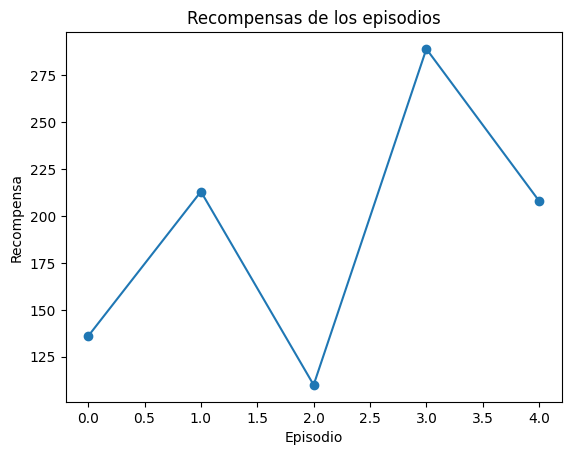

In [32]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

def train_and_visualize(env_name, num_timesteps=10000):
    # Crear el entorno
    env = gym.make(env_name)

    # Envolver el entorno con la VecEnv para compatibilidad con SB3
    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    # Crear el modelo PPO
    model = PPO("MlpPolicy", env, verbose=1)

    # Entrenar el modelo
    model.learn(total_timesteps=num_timesteps)

    # Visualizar el agente entrenado
    visualize_agent(env, model)

def visualize_agent(env, model, num_episodes=5):
    # Visualizar el agente entrenado
    rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward = 0

        while True:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)

    # Plotear las recompensas de los episodios
    plt.plot(rewards, marker='o')
    plt.title('Recompensas de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.show()

if __name__ == "__main__":
    # Entrenar y visualizar el agente en el entorno CartPole-v1
    train_and_visualize("CartPole-v1", num_timesteps=10000)

In [34]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

def train_and_visualize(env_name, num_timesteps=10000):
    # Crear el entorno
    env = gym.make(env_name)
    # Crear un objeto Monitor para manejar el renderizado y la recopilación de estadísticas
    env = Monitor(env, 'logs/')

    # Envolver el entorno con la VecEnv para compatibilidad con SB3
    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    # Crear el modelo PPO
    model = PPO("MlpPolicy", env, verbose=1)

    # Entrenar el modelo
    model.learn(total_timesteps=num_timesteps)

    # Visualizar el agente entrenado
    visualize_agent(env, model)

def visualize_agent(env, model, num_episodes=5):
    # Visualizar el agente entrenado
    rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward = 0

        while True:
            # Renderizar el entorno
            env.render()

            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)

    # Plotear las recompensas de los episodios
    plt.plot(rewards, marker='o')
    plt.title('Recompensas de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.show()

    # Cerrar el entorno después de visualizar
    env.close()

if __name__ == "__main__":
    # Entrenar y visualizar el agente en el entorno CartPole-v1
    train_and_visualize("CartPole-v1", num_timesteps=10000)

Using cpu device


AssertionError: The algorithm only supports (<class 'gymnasium.spaces.box.Box'>, <class 'gymnasium.spaces.discrete.Discrete'>, <class 'gymnasium.spaces.multi_discrete.MultiDiscrete'>, <class 'gymnasium.spaces.multi_binary.MultiBinary'>) as action spaces but Discrete(2) was provided

Inicialización: Inicializamos la tabla Q, que es una matriz donde las filas representan estados y las columnas representan acciones. Inicialmente, los valores en esta tabla pueden ser aleatorios.

Elección de Acción: Para cada episodio, observamos el estado actual y elegimos una acción. La elección de la acción puede ser determinista o basada en una política de exploración, que se introduce con el parámetro epsilon.

Interacción con el Entorno: Tomamos la acción elegida y observamos la recompensa del entorno. También observamos el nuevo estado.

Actualización de Q-Value: Actualizamos el valor Q para la acción tomada en el estado actual utilizando la fórmula de actualización de Q:

In [ ]:
Q[state, action] = Q[state, action] + learning_rate * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

* learning_rate es la tasa de aprendizaje.
* gamma es el factor de descuento que representa la importancia de las recompensas futuras.
* Gamma : Este parámetro controla la importancia de las recompensas futuras. Un valor más alto significa que se dará más peso a las recompensas a largo plazo.
* Epsilon: Este parámetro controla la probabilidad de elegir una acción aleatoria en lugar de la mejor acción según la tabla Q. A medida que epsilon disminuye con el tiempo, el agente tiende a explotar más y explorar menos.

In [ ]:
actions = ['left', 'right']
epsilon = 0.9
alpha = 0.1
gamma = 0.9
max_episodes = 1000

In [ ]:
def build_q_table(n_states, actions):
    table = pd.DataFrame(np.zeros((n_states, len(actions))),
                         columns = actions)
    return table